## API Function Definitions

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Input values
fleet_size = [50000,10000,1000]
mean_dvmt = [45,35,25]
temp_c = [40,30,20,10,0,-10,-20]
pev_type = ['PHEV20','PHEV50','BEV100','BEV250']
pev_dist = ['EQUAL_DIST','PHEV_DOM','BEV_DOM']
vehicle_class_dist = ['Sed20_Suv80','Sed50_Suv50','Sed80_Suv20']
day_of_week = ['weekday','weekend']
home_access = ['HA100','HA75','HA50',]
home_power_dist = ["L2"]
work_power_dist = ['L2_20','L2_50','L2_100']
pref_dist = ['Home60','Home80','Home100']
dest_type = ['Home','Public','Work']
dest_chg_level = ['L1','L2','L3']


In [5]:
def selection_API_Run(fleet_size,mean_dvmt,temp_c,pev_type,pev_dist,vehicle_class_dist,home_access,work_power_dist,pref_dist,dest_chg_level,day_of_week,dest_type,test=0):    
    params=[]
    #Don't need home_power_dist since it only has one choice
    #day_of_week and dest_type are used to generate plots- therefore all selections are used (and they are omitted from choice selection)
    
    for var_name,var in zip(["fleet size","mean daily vehicle miles traveled","temperature (C)","PEV distribution","vehicle class distribution","% of homes with home charging access","% of L2 work charging (remainder is L1)","percent of charging done at home (for those who have it)"],[fleet_size,mean_dvmt,temp_c,pev_dist,vehicle_class_dist,home_access,work_power_dist,pref_dist]):
        if test!=1:
            print("Please select a value for "+var_name+".")
            for i in range(0,len(var)):
                print(str(i)+") "+str(var[i]))   
            while True:
                selection=-1
                try:
                    selection = int(input("Enter an integer selection from above (Ex. 0, 1, 2..): ")) #User selects parameter choice from list
                except:
                    pass
                if selection in list(range(len(var))):
                    break
                else:
                    print("Select just one of the numbers corresponding to a choice from the above listed parameter values.")
             
            params.append(var[selection])         #Will be a list of parameters in the order listed in the for loop
            print("\n")
        else:
            print(var[0])
            params.append(var[0])

    #Generate load profiles for home, public, and work on both weekends and weekdays and for different charger levels according to the selected parameters
    print("Running simulation according to selected parameters...")
    record_json={}
    for dow in day_of_week:
        record_json[dow]={}
        for location in dest_type:
            for chg_level in dest_chg_level:
                print(dow,location,chg_level)
                #Skip home/work level 3 or public level 1
                if (location=="Home" and chg_level!="L3") or (location=="Public" and chg_level!="L1") or (location=="Work" and chg_level!="L3"): 
                    for pev in pev_type:
                        if (pev[0:4]=="PHEV" and chg_level=="L3"): #Skip PHEV and L3
                            pass
                        else:
                            url = """https://devstage.nrel.gov/api/evi-pro-lite-beta/load-profile?fleet_size=%s&mean_dvmt=%s&temp_c=%s&pev_dist=%s&vehicle_class_dist=%s&home_access=%s&home_power_dist=L2&work_power_dist=%s&pref_dist=%s&dest_chg_level=%s&day_of_week=%s&dest_type=%s&pev_type=%s""" %(params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],chg_level,dow,location,pev)
                            url=url.replace("\\", "")
                            record_str = requests.get(url).text
                            record_str = record_str.replace("'", "\"")
                            raw_json=json.loads(record_str)
                            try:
                                raw_json['load_profile']
                            except KeyError:
                                print("Possible error:",raw_json['errors'])
                                print(dow,location,chg_level,pev)
                                #print(url)
                                current_results = np.zeros(96)
                            else:
                                current_results=[float(i) for i in raw_json['load_profile']] #Parse the JSON
                                #If we haven't saved data for this location and charger level, create a new dictionary entry. Otherwise, add to the existing
                            try:
                                record_json[dow][location,chg_level]
                            except KeyError:
                                record_json[dow][location,chg_level] = current_results
                            else:
                                record_json[dow][location,chg_level]=[x + y for x, y in zip(record_json[dow][location,chg_level], current_results)]
                else:
                    pass
    record_json_df=pd.DataFrame(record_json)
    print("Simulation Run Complete")
    return record_json_df

In [4]:
#Run user selection
result = selection_API_Run(fleet_size,mean_dvmt,temp_c,pev_type,pev_dist,vehicle_class_dist,home_access,work_power_dist,pref_dist,dest_chg_level,day_of_week,dest_type,2)

Please select a value for fleet size.
0) 50000
1) 10000
2) 1000


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Please select a value for mean daily vehicle miles traveled.
0) 45
1) 35
2) 25


Enter an integer selection from above (Ex. 0, 1, 2..):  asdf


Select just one of the numbers corresponding to a choice from the above listed parameter values.


Enter an integer selection from above (Ex. 0, 1, 2..):  123


Select just one of the numbers corresponding to a choice from the above listed parameter values.


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Please select a value for temperature (C).
0) 40
1) 30
2) 20
3) 10
4) 0
5) -10
6) -20


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Please select a value for PEV distribution.
0) EQUAL_DIST
1) PHEV_DOM
2) BEV_DOM


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Please select a value for vehicle class distribution.
0) Sed20_Suv80
1) Sed50_Suv50
2) Sed80_Suv20


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Please select a value for % of homes with home charging access.
0) HA100
1) HA75
2) HA50


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Please select a value for % of L2 work charging (remainder is L1).
0) L2_20
1) L2_50
2) L2_100


Enter an integer selection from above (Ex. 0, 1, 2..):  2




Please select a value for percent of charging done at home (for those who have it).
0) Home60
1) Home80
2) Home100


Enter an integer selection from above (Ex. 0, 1, 2..):  0




Running simulation according to selected parameters...
weekday Home L1
weekday Home L2
weekday Home L3
weekday Public L1
weekday Public L2
weekday Public L3
weekday Work L1
Possible error: ['Load profile not found']
weekday Work L1 PHEV20
https://devstage.nrel.gov/api/evi-pro-lite-beta/load-profile?fleet_size=50000&mean_dvmt=45&temp_c=40&pev_dist=EQUAL_DIST&vehicle_class_dist=Sed20_Suv80&home_access=HA100&home_power_dist=L2&work_power_dist=L2_100&pref_dist=Home60&dest_chg_level=L1&day_of_week=weekday&dest_type=Work&pev_type=PHEV20
Possible error: ['Load profile not found']
weekday Work L1 PHEV50
https://devstage.nrel.gov/api/evi-pro-lite-beta/load-profile?fleet_size=50000&mean_dvmt=45&temp_c=40&pev_dist=EQUAL_DIST&vehicle_class_dist=Sed20_Suv80&home_access=HA100&home_power_dist=L2&work_power_dist=L2_100&pref_dist=Home60&dest_chg_level=L1&day_of_week=weekday&dest_type=Work&pev_type=PHEV50
Possible error: ['Load profile not found']
weekday Work L1 BEV100
https://devstage.nrel.gov/api/e

## Plotting

In [6]:
#Generate list of times for x axis
start = datetime(2019,1,1,0,0,0)
end = datetime(2019,1,2,0,0,0)
seconds = (end - start).total_seconds()
step = timedelta(minutes=15)
time_array = []
for i in range(0, int(seconds), int(step.total_seconds())):
    time_array.append(start + timedelta(seconds=i))
time_array = [i.time().strftime('%H:%M') for i in time_array]

##Stack Plot
def loadPlotting(day):
    fig = plt.figure(figsize = (12,5))
    ax = plt.axes()
    xaxis_labels = [(x * 15.0)/60.0 for x in range(0,96)]

    ax.stackplot(xaxis_labels,result[day][0],result[day][1],result[day][2],result[day][3],result[day][4],result[day][5])
    
    plt.legend(result['weekday'].keys(),fontsize = 14,loc = 'upper left')
    plt.xlabel('Hour of Day',size=18)
    plt.ylabel('Grid Load [kW]',size=18)
    plt.title(day.capitalize()+' Fleet-wide Grid load',size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim([0,180000])
    ax.set_xlim([0,24])
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))   


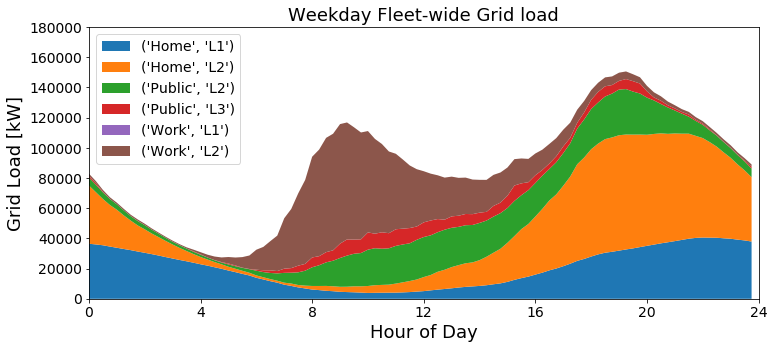

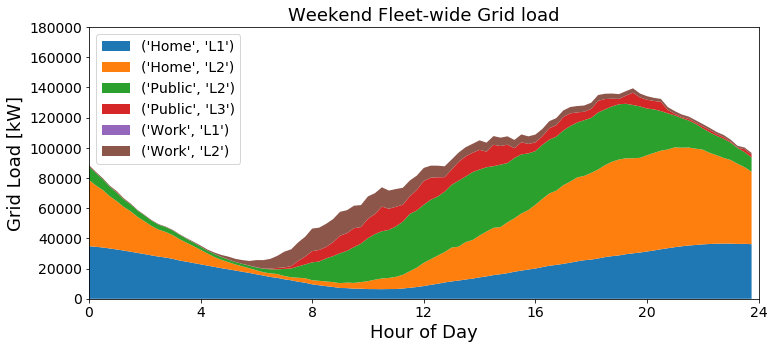

In [7]:
loadPlotting('weekday')
loadPlotting('weekend')